# P1W3D2PM - Clustering - Part 2

## A. Setup

In [1]:
import numpy as np
np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline

## B. Agglomerative Clustering

In [2]:
# Generate Data

X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)

In [3]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(linkage="complete").fit(X)

In [4]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [5]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

### Clustering for Image Segmentation

In [6]:
# Download the Image

import urllib.request
image_url = 'https://raw.githubusercontent.com/ardhiraka/FSDS_Guidelines/master/p1/v3/w3/P1W3D2PM%20-%20Clustering%20-%20Part%202.png'
filename = 'ladybug.png'

urllib.request.urlretrieve(image_url, filename)

('ladybug.png', <http.client.HTTPMessage at 0x7fe0ab1d7b50>)

In [7]:
# Read the Image

from matplotlib.image import imread
image = imread(filename)
image.shape

(533, 800, 3)

In [8]:
# Clustering using KMeans

%%time
X = image.reshape(-1, 3)

from sklearn.cluster import KMeans
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

CPU times: user 52.4 s, sys: 380 ms, total: 52.8 s
Wall time: 52.5 s


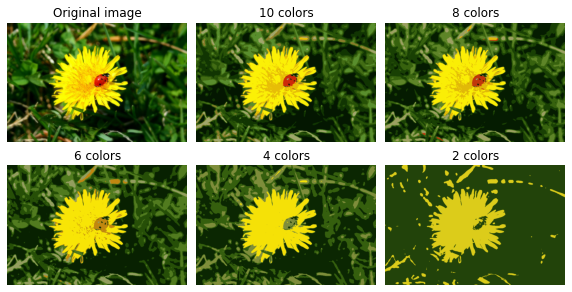

In [9]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

### Clustering for Preprocessing

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [10]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

Let's split it into a training set and a test set:

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's fit a Logistic Regression model and evaluate it on the test set:

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [13]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [14]:
%%time
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

CPU times: user 13.5 s, sys: 9.56 s, total: 23.1 s
Wall time: 11.9 s


In [15]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?

In [16]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

How about that? We reduced the error rate by over 28%! But we chose the number of clusters $k$ completely arbitrarily, we can surely do better.

---
Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

**Warning**: the following cell may take close to 20 minutes to run, or more depending on your hardware.

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 70))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Let's see what the best number of clusters is:

In [18]:
grid_clf.best_params_

{'kmeans__n_clusters': 69}

In [19]:
grid_clf.score(X_test, y_test)

0.9777777777777777